Plotting by averaging results from `Ryzen-OrangePi` and `Mac-OrangePi`

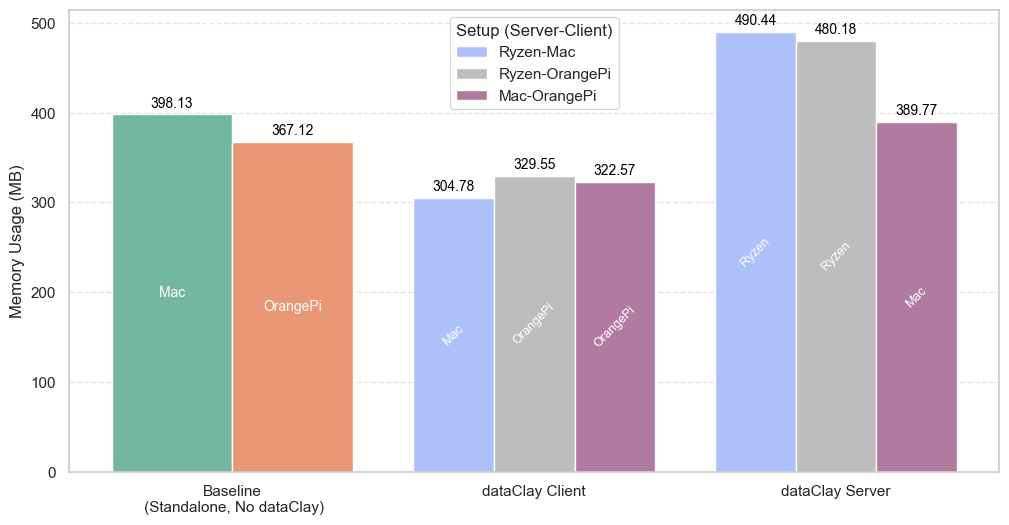

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch


df_server2mac = pd.read_csv('server2mac_table.csv')
df_server2orangepi = pd.read_csv('server2orangepi_table.csv')
df_mac2orangepi = pd.read_csv('mac2orangepi_table.csv')

df_combined = pd.concat([
    df_server2mac.assign(Source='Ryzen-Mac'),
    df_server2orangepi.assign(Source='Ryzen-OrangePi'),
    df_mac2orangepi.assign(Source='Mac-OrangePi')
])

df_filtered = df_combined[df_combined['Experiment'].isin(['baseline', 'dC-Client', 'dC-Server'])].copy()

baseline_sources = ['Ryzen-OrangePi', 'Mac-OrangePi']
baseline_df = df_filtered[(df_filtered['Experiment'] == 'baseline') & (df_filtered['Source'].isin(baseline_sources))]

avg_memory_mean = baseline_df['Memory Usage (MB)_mean'].mean()
avg_memory_std = baseline_df['Memory Usage (MB)_std'].mean()
avg_total_time = baseline_df['Total Time Mean'].mean()

new_row = pd.DataFrame({
    'Experiment': ['baseline'],  
    'Memory Usage (MB)_mean': [avg_memory_mean],
    'Memory Usage (MB)_std': [avg_memory_std],
    'Total Time Mean': [avg_total_time],
    'Source': ['average']  
})
df_filtered = pd.concat([df_filtered, new_row], ignore_index=True)
df_filtered = df_filtered[~((df_filtered['Experiment'] == 'baseline') & (df_filtered['Source'].isin(baseline_sources)))]

df_filtered['Experiment'] = df_filtered['Experiment'].replace({
    'baseline': 'Baseline\n (Standalone, No dataClay)',
    'dC-Client': 'dataClay Client',
    'dC-Server': 'dataClay Server'
})

df_filtered = df_filtered[
    ~(df_filtered['Experiment'] == 'Baseline\n (Standalone, No dataClay)') | 
    (df_filtered['Source'] != 'Mac-OrangePi')
]

experiment_order = [
    "Baseline\n (Standalone, No dataClay)",
    "dataClay Client",
    "dataClay Server"
]
df_filtered['Experiment'] = pd.Categorical(df_filtered['Experiment'], categories=experiment_order, ordered=True)

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 6))

baseline_df = df_filtered[df_filtered['Experiment'] == "Baseline\n (Standalone, No dataClay)"]
source_order_baseline = ['Ryzen-Mac', 'average']
baseline_palette = {'Ryzen-Mac': '#66c2a5', 'average': '#fc8d62', }

bar_baseline = sns.barplot(
    data=baseline_df,
    x='Experiment',
    y='Memory Usage (MB)_mean',
    hue='Source',
    hue_order=source_order_baseline,
    palette=baseline_palette,
    ax=ax,
    dodge=True,
    legend=False
)

baseline_labels = {"Ryzen-Mac": "Mac", "average": "OrangePi"}
for i, patch in enumerate(bar_baseline.patches):
    x_center = patch.get_x() + patch.get_width()/2.
    y_center = patch.get_height()/2.
    source = source_order_baseline[i]
    label = baseline_labels[source]
    ax.text(x_center, y_center, label, ha='center', va='center', color='white', fontsize=10)

dataclay_df = df_filtered[df_filtered['Experiment'].isin(["dataClay Client", "dataClay Server"])]
pivot_dc = dataclay_df.pivot(index='Experiment', columns='Source', values='Memory Usage (MB)_mean')

source_order_dataclay = ['Ryzen-Mac', 'Ryzen-OrangePi', 'Mac-OrangePi']
dataclay_palette = {"Ryzen-Mac": "#aec0fa",       
                    "Ryzen-OrangePi": "#bdbdbd",  
                    "Mac-OrangePi": "#B07AA1"}    

client_labels = {"Ryzen-Mac": "Mac", "Ryzen-OrangePi": "OrangePi", "Mac-OrangePi": "OrangePi"}  # MODIFIED: for dataclay client labels
server_labels = {"Ryzen-Mac": "Ryzen", "Ryzen-OrangePi": "Ryzen", "Mac-OrangePi": "Mac"}  # MODIFIED: for dataclay server labels

x_positions = {exp: i for i, exp in enumerate(experiment_order)}
total_bar_width = 0.8
n_hues = len(source_order_dataclay)
bar_width = total_bar_width / n_hues

for exp in ["dataClay Client", "dataClay Server"]:
    x_center_group = x_positions[exp]
    if exp == "dataClay Client":
        label_map = client_labels  # MODIFIED: use client labels for dataclay client
    else:
        label_map = server_labels  # MODIFIED: use server labels for dataclay server
    for j, source in enumerate(source_order_dataclay):
        x = x_center_group - total_bar_width/2 + (j + 0.5) * bar_width
        if source in pivot_dc.columns and exp in pivot_dc.index:
            val = pivot_dc.loc[exp, source]
            if pd.notna(val):
                ax.bar(x, val, color=dataclay_palette[source], width=bar_width)
                ax.text(
                    x, val/2, label_map[source],
                    ha='center', va='center', color='white', fontsize=9, rotation=45
                )

# ADDED: Annotate numeric values on top for all bars (horizontal, in black)
for patch in ax.patches:
    height = patch.get_height()
    if height != 0:
        ax.annotate(f'{height:.2f}', (patch.get_x() + patch.get_width()/2., height),
                    ha='center', va='bottom', xytext=(0, 3),
                    textcoords='offset points', color='black', fontsize=10)

# ----- Create a Custom Legend -----
dataclay_handles = [
    Patch(facecolor="#aec0fa", label='Ryzen-Mac'),
    Patch(facecolor="#bdbdbd", label='Ryzen-OrangePi'),
    Patch(facecolor="#B07AA1", label='Mac-OrangePi')
]
custom_handles = dataclay_handles
ax.legend(handles=custom_handles, title='Setup (Server-Client)', loc='best')

ax.grid(axis='x', linestyle='', alpha=0.5)
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_ylabel('Memory Usage (MB)')
ax.set_xlabel('')

pdf_path = "../data/memory_usage_plot.pdf"
plt.savefig(pdf_path, format="pdf", bbox_inches="tight")
plt.show()
plt.close()

# Runtimes plot

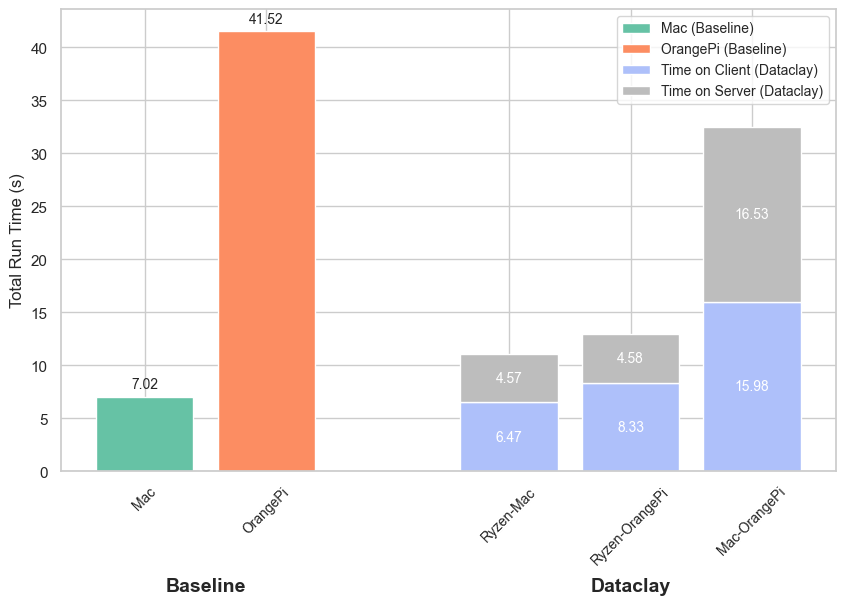

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

df_server2mac = pd.read_csv('server2mac_table.csv')
df_server2orangepi = pd.read_csv('server2orangepi_table.csv')
df_mac2orangepi = pd.read_csv('mac2orangepi_table.csv')

baseline_rows = pd.concat([df_server2orangepi[df_server2orangepi['Experiment'] == 'baseline'], 
                           df_mac2orangepi[df_mac2orangepi['Experiment'] == 'baseline']])

average = baseline_rows.mean(numeric_only=True)
average_row = pd.DataFrame([average])
average_row.insert(0, 'Experiment', 'baseline')  # renaming as baseline again but its actually the average 

df_server2orangepi.loc[df_server2orangepi['Experiment'] == 'baseline'] = average_row.values
df_mac2orangepi.loc[df_mac2orangepi['Experiment'] == 'baseline'] = average_row.values


baseline_devices = ["Mac", "OrangePi"]

dataclay_sources = {
    "Ryzen-Mac": df_server2mac,
    "Ryzen-OrangePi": df_server2orangepi,
    "Mac-OrangePi": df_mac2orangepi
}

baseline_values = []
for device, df in zip(baseline_devices, [df_server2mac, df_server2orangepi]):
    baseline_val = df.loc[df['Experiment'] == 'baseline', 'Total Time Mean']
    baseline_values.append(baseline_val.values[0] if not baseline_val.empty else 0)

dc_client_values, dc_server_values = [], []
for source, df in dataclay_sources.items():
    dc_client_val = df.loc[df['Experiment'] == 'dC-Client', 'Total Time Mean']
    dc_server_val = df.loc[df['Experiment'] == 'dC-Server', 'Total Time Mean']

    dc_client_values.append(dc_client_val.values[0] if not dc_client_val.empty else 0)
    dc_server_values.append(dc_server_val.values[0] if not dc_server_val.empty else 0)

x_baseline = [0, 1]   # Two bars for "Baseline" (Mac & OrangePi)
x_dataclay = [3, 4, 5] # Three bars for "Dataclay" (Ryzen-Mac, Ryzen-OrangePi, Mac-OrangePi)

fig, ax = plt.subplots(figsize=(10, 6))

baseline_colors = sns.color_palette("Set2", n_colors=2)

dc_client_color = "#aec0fa"  
dc_server_color = "#bdbdbd"  

# Plot Baseline bars
for i, val in enumerate(baseline_values):
    ax.bar(x_baseline[i], val, color=baseline_colors[i], width=0.8)
    ax.text(x_baseline[i], val + 0.5, f"{val:.2f}", ha='center', va='bottom', fontsize=10)

# Plot Dataclay bars (stacked)
for i, (client_val, server_val) in enumerate(zip(dc_client_values, dc_server_values)):
    ax.bar(x_dataclay[i], client_val, color=dc_client_color, width=0.8)
    ax.bar(x_dataclay[i], server_val, bottom=client_val, color=dc_server_color, width=0.8)

    # Annotate stacked segments
    if client_val > 0:
        ax.text(x_dataclay[i], client_val / 2, f"{client_val:.2f}", ha='center', va='center', color='white', fontsize=10)
    if server_val > 0:
        ax.text(x_dataclay[i], client_val + server_val / 2, f"{server_val:.2f}", ha='center', va='center', color='white', fontsize=10)

all_x = x_baseline + x_dataclay
all_labels = baseline_devices + list(dataclay_sources.keys())  # First two are baseline, last three are dataclay
ax.set_xticks(all_x)
ax.set_xticklabels(all_labels, fontsize=10, rotation=45)

ax.text(sum(x_baseline)/len(x_baseline), -10, "Baseline", ha='center', va='top', fontsize=14, fontweight='bold')
ax.text(sum(x_dataclay)/len(x_dataclay), -10, "Dataclay", ha='center', va='top', fontsize=14, fontweight='bold')

ax.set_ylabel("Total Run Time (s)")
ax.set_xlabel("")  # Remove x-axis label

legend_handles = [
    Patch(facecolor=baseline_colors[0], label="Mac (Baseline)"),
    Patch(facecolor=baseline_colors[1], label="OrangePi (Baseline)"),
    Patch(facecolor=dc_client_color, label="Time on Client (Dataclay)"),
    Patch(facecolor=dc_server_color, label="Time on Server (Dataclay)")
]
ax.legend(handles=legend_handles, fontsize=10)


pdf_path = "../data/runtimes_plot.pdf"
plt.savefig(pdf_path, format="pdf", bbox_inches="tight")

plt.show()
plt.close()